100%|███████████████████████████████████████| 793/793 [00:00<00:00, 1253.87it/s]


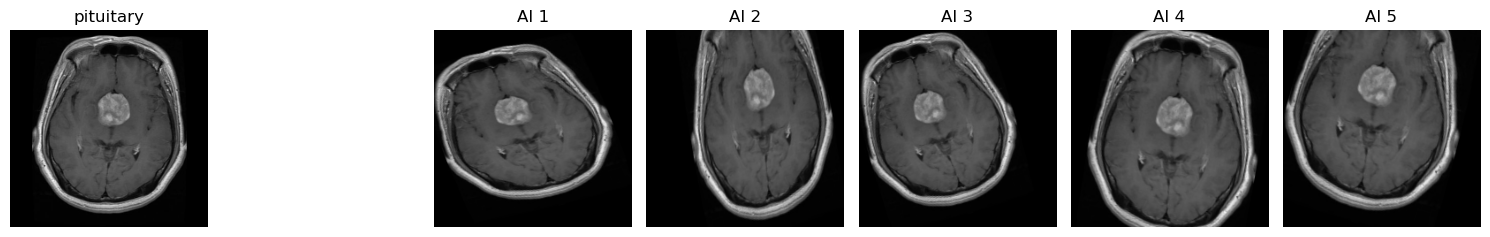

In [9]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image, display
import imutils
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import keras
import tensorflow.keras as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils

# Load data and preprocess images (as you provided)
labels = ['glioma', 'meningioma', 'neurocytoma', 'notumor', 'pituitary', 'schwannoma']
X = []
y = []

image_size = 224

for i in labels:
    folderPath = os.path.join('Tumor1/Training', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

X = np.array(X)
y = np.array(y)


from sklearn.preprocessing import LabelEncoder
# Perform label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

from sklearn.model_selection import train_test_split
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.10, random_state=42)

# Define an image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

from tensorflow.keras.utils import to_categorical
# Convert integer labels to one-hot encoded vectors
y_train_onehot = to_categorical(y_train, num_classes=len(labels))
y_val_onehot = to_categorical(y_val, num_classes=len(labels))


# Visualize data augmentation for a specific image
sample_index = 0  # Choose the index of the image you want to visualize
sample_image = X_train[sample_index]
sample_label = y_train[sample_index]  # Get the corresponding label

# Reshape the image to (1, height, width, channels) as required by the generator
sample_image = np.expand_dims(sample_image, axis=0)

# Convert pixel values to float and rescale to [0, 1] range
sample_image = sample_image.astype(np.float32) / 255.0

# Generate augmented images from the sample image
augmented_images = []
num_augmented_images = 5  # Number of augmented images to generate
for _ in range(num_augmented_images):
    augmented = datagen.flow(sample_image, batch_size=1)
    augmented_images.append(augmented[0][0])  # Get the augmented image

# Create a figure with subplots and adjust spacing
plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.4)  # Adjust the width space between subplots

# Plot the original image
plt.subplot(1, num_augmented_images + 2, 1)
plt.imshow(sample_image[0])
plt.title(f'{labels[sample_label]}')
plt.axis('off')

# Plot the augmented images
for i, augmented_image in enumerate(augmented_images):
    plt.subplot(1, num_augmented_images + 2, i + 3)
    plt.imshow(augmented_image)
    plt.title(f'AI {i + 1}')
    plt.axis('off')

plt.tight_layout()  # Adjust layout after all subplots are defined
plt.show()


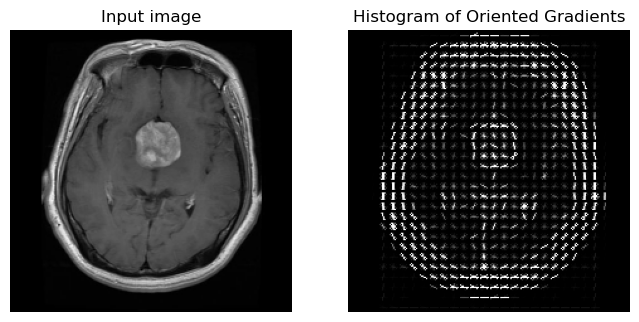

In [19]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

# Choose an index for the image you want to process
image_index = 0  # Change this to the desired index

# Load the chosen image
chosen_image = X_train[image_index]

# Convert the image to grayscale if necessary
chosen_image_gray = cv2.cvtColor(chosen_image, cv2.COLOR_BGR2GRAY)

# Apply HOG feature extraction
fd, hog_image = hog(chosen_image_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

# Plot the original image
ax1.axis('off')
ax1.imshow(chosen_image)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Plot the HOG feature visualization
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')

plt.show()


In [20]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import cv2

# Choose an index for the image you want to process
image_index = 0  # Change this to the desired index

# Load the chosen image
chosen_image = X_train[image_index]

# Convert the image to grayscale if necessary
chosen_image_gray = cv2.cvtColor(chosen_image, cv2.COLOR_BGR2GRAY)

# Apply HOG feature extraction
fd, hog_image = hog(chosen_image_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Save the HOG image
hog_image_path = f'hog_image_{image_index}.png'
cv2.imwrite(hog_image_path, (hog_image_rescaled * 255).astype(int))

print(f'HOG image saved as {hog_image_path}')


HOG image saved as hog_image_0.png


In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

# Choose an index for the image you want to process
image_index = 0  # Change this to the desired index

# Load the chosen image
chosen_image = X_train[image_index]

# Convert the image to grayscale if necessary
chosen_image_gray = cv2.cvtColor(chosen_image, cv2.COLOR_BGR2GRAY)

# Apply Local Binary Pattern (LBP) feature extraction
radius = 3
n_points = 8 * radius
lbp_image = local_binary_pattern(chosen_image_gray, n_points, radius, method='uniform')

# Rescale LBP values to fit into the 0-255 range
lbp_image_rescaled = ((lbp_image - np.min(lbp_image)) / (np.max(lbp_image) - np.min(lbp_image))) * 255

# Convert LBP image to integer type
lbp_image_rescaled = lbp_image_rescaled.astype(np.uint8)

# Save the LBP image
lbp_image_path = f'lbp_image_{image_index}.png'
cv2.imwrite(lbp_image_path, lbp_image_rescaled)

print(f'LBP image saved as {lbp_image_path}')


# def extract_lbp_features(images):
#     lbp_features = []
#     for img in tqdm(images):
#         # Convert the image to grayscale
#         gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         # Compute LBP features
#         radius = 3
#         n_points = 8 * radius
#         lbp_feature = local_binary_pattern(gray_img, n_points, radius, method='uniform').ravel()
#         lbp_features.append(lbp_feature)
#     return np.array(lbp_features)

LBP image saved as lbp_image_0.png
